In [1]:
'''
compute log prob increase, and analyze the attention of the last token'Q and the context's K
'''


from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import TraceDict

device="cuda:0"
model_path = "/home/pc/data/qixun/checkpoints/llama-2-7b"
model = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 23.45 GiB of which 18.75 MiB is free. Process 1205548 has 1.86 GiB memory in use. Process 1214969 has 12.37 GiB memory in use. Including non-PyTorch memory, this process has 9.17 GiB memory in use. Of the allocated memory 8.79 GiB is allocated by PyTorch, and 1.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%cd /home/pc/data/qixun/codes/Quick_LLM

/home/pc/data/qixun/codes/Quick_LLM


/home/pc/data/qixun/conda_envs/fv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import transformers
from transformers import LlamaForCausalLM
from networks.my_llama_attn_block import CustomLlamaAttention
MAX_NEW_TOKENS=2
print(torch.Size([model.config.hidden_size]))

torch.Size([4096])


In [ ]:
def cal_log_pred_prob(target_word, model, tokenizer, rep, word_embeddings):
    assert rep.shape == torch.Size([model.config.hidden_size])
    target_token=tokenizer(target_word, return_tensors='pt')['input_ids'].squeeze().to(device)
    assert target_token.shape[0]==2 # some target words may longer than 1 token
    target_token=target_token[1] # target_token[0] is <s>
    
    
    target_word_embedding=word_embeddings[target_token]
    sum_exp=torch.sum(torch.exp(torch.sum(word_embeddings * rep, dim=1)), dim=0)
    target_exp=torch.exp(torch.dot(target_word_embedding, rep))
    log_prob=torch.log(target_exp/sum_exp)
    return log_prob

def get_output_text(model, tokenizer, prompt, device):
    input_tks = tokenizer(prompt, return_tensors='pt').to(device)
    output_tokens = model.generate(input_tks.input_ids, top_p=0.9, temperature=0.1,
                                max_new_tokens=MAX_NEW_TOKENS)
    output_text = tokenizer.decode(output_tokens.squeeze()[-MAX_NEW_TOKENS:])
    return output_text

def get_tokens(model, tokenizer, prompt, device):
    tokens = tokenizer(prompt, return_tensors='pt').to(device)
    return tokens['input_ids']

def get_tk_words(tokenizer, tks):
    '''
    map the tokens back to the words. original words may be split.
    '''
    tk_words=[]
    for i in range(tks.shape[0]):
        tk_words.append(tokenizer.decode(tks[i]))
    return tk_words

def jaccard(a,b):
    set_a=set(a)
    set_b = set(b)
    return len(set_a.intersection(set_b))/len(set_a.union(set_b))


In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

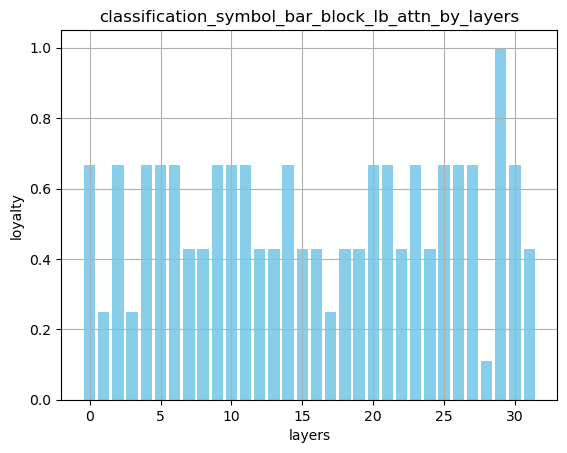

In [ ]:
'''
compute the log probability increase of the layers: log p(w| VO ) - log p(w| before O)
or the heads: log p(w| V[h] @ O [h]) - log p(w| before O)
'''
task='cs_bar' # which prompt to test
attn_obj='all' # labels: compute the attn between the last token's Q and context's labels'K; all: compute the attn between the last token's Q and all context tokens'K
spec_str='' # flexible str to mark the saved figures
ana_module='spec_layer' # all heads: compute the attn of all heads; by_head: compute the attn of the most significant heads; 
# spec_head: heatmap of attn diff of all heads; spec_layer: visualize the attn of a specified layer

if task=='a':
    task_name="antonym"
    prompt="difficult: easy\nwrong: right\ngood: bad\nwin: lose\ndangerous: safe\nfast:"
    target_word="slow"
if task=='cs_bar':
    task_name="classification_symbol_bar"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\none:"
    target_word="bar"
if task=='cs_foo':
    task_name="classification_symbol_foo"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\njump:"
    target_word="foo"
elif task=='ss_pos':
    task_name="simple_sentiment"
    prompt="revolutionary: positive\nbad: negative\ninsightful: positive\nselfish: negative\nbeautiful: positive\noutdated: negative\nclean: "
    spec_str+="_pos"
    target_word="positive"
elif task=='ss_neg':
    task_name="simple_sentiment"
    prompt="revolutionary: positive\nbad: negative\ninsightful: positive\nselfish: negative\nbeautiful: positive\noutdated: negative\nvulgar: "
    spec_str+='_neg'
    target_word="negative"
elif task=='sss_foo':
    task_name="simple_sentiment_symbol"
    prompt="good: foo\nbad: bar\ninsightful: foo\nselfish: bar\nbeautiful: foo\nboring: bar\nstrong: "
    spec_str+='_foo'
    target_word="foo"
elif task=='sss_bar':
    task_name="simple_sentiment_symbol"
    prompt="good: foo\nbad: bar\ninsightful: foo\nselfish: bar\nbeautiful: foo\nboring: bar\nvulgar: "
    spec_str+='_bar'
    target_word="bar"
elif task=='ss2':
    task_name="simple_sentiment_2_words"
    prompt="revolutionary idea: positive\nbad ass: negative\ninsightful finding: positive\nselfish man: negative\nbeautiful bird: positive\noutdated book: negative\nfilthy idea: "
    target_word="negative"
elif task=='s_adv1':
    task_name="sentiment_adv1"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    target_word="t"
elif task=='s_adv2':
    task_name="sentiment_adv2"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    target_word="t"
elif task=='s_adv3':
    task_name="sentiment_adv3"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    print(get_tokens(model, tokenizer, prompt, device))
    target_word="t"
elif task=='s':
    task_name="sentiment"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use. A:"
    target_word="bar"

input_tokens = tokenizer(prompt, return_tensors='pt').to(device)
n_layers=model.config.num_hidden_layers
n_heads=model.config.num_attention_heads
hidden_dim=model.config.hidden_size
head_dim=hidden_dim//n_heads
attn_O=[f'model.layers.{l}.self_attn.o_proj' for l in range(n_layers)]
attn_V=[f'model.layers.{l}.self_attn.v_proj' for l in range(n_layers)]
attn_Q=[f'model.layers.{l}.self_attn.q_proj' for l in range(n_layers)]
attn_K=[f'model.layers.{l}.self_attn.k_proj' for l in range(n_layers)]
n_top_layers=10
n_top_heads=10
n_top_preds=5 # for jaccard similarity computation
block_obj='block_lb_attn'
block_by_heads=False
# print(word_embeddings.weight.shape) # torch.Size([32000, 4096])

word_embeddings=model.get_input_embeddings().weight

def block_head(edit_layer, head_to_block):
    def block_head_(output, layer_name):
        current_layer = int(layer_name.split(".")[2])
        if current_layer == edit_layer: # 遍历到edit_layer, 该修改了
            if isinstance(output, tuple):
                # output[0].shape [1,12,4096] [1, num_token, dim_hidden]
                if head_to_block==-1:
                    output[0][:, :, :] = 0 # block all heads
                else:
                    output[0][:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
            else:
                if head_to_block==-1:
                    output[:, :, :] = 0 # block all heads
                else:
                    output[:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
        else:
            return output
    return block_head_



with TraceDict(model, layers=attn_O+attn_Q+attn_V+attn_K, retain_input=True, retain_output=True) as _:
    pred=model(**input_tokens).logits[:, -1]
clean_top_tks=torch.topk(pred, n_top_preds).indices.squeeze(0)

#block_top_tks=torch.zeros(n_layers, n_heads, n_top_preds).to(device)
if block_obj=='block_lb_attn':
    label_poss=torch.where(input_tokens['input_ids'][0]==13)[0]-1  # find '\n', and use its previous token
    #print(label_poss)
    jaccard_scores_block_lb_attn=torch.zeros(n_layers).to(device)
    spec_str+='_block_lb_attn_by_layers'
    for l in range(n_layers):
        tem_attn=model.model.layers[0].self_attn
        model.model.layers[0].self_attn = CustomLlamaAttention(model.config).half().to(device) # .half() is torch.float16
        model.model.layers[0].self_attn.set_label_positions(label_poss)
        block_lb_attn_pred=model(**input_tokens).logits[0, -1]
        model.model.layers[0].self_attn=tem_attn
        jaccard_scores_block_lb_attn[l]= jaccard(clean_top_tks.tolist(), torch.topk(block_lb_attn_pred, n_top_preds).indices.tolist() )

        plt.bar(range(n_layers), jaccard_scores_block_lb_attn.detach().cpu().numpy(), color='skyblue')
        plt.title(task_name+spec_str)
        plt.xlabel('layers')
        plt.ylabel('loyalty')
        plt.grid(True)
        save_dir=f'./visualization/loyalty/block_lb_attn'
else:
    if block_by_heads:
        jaccard_scores=torch.zeros(n_layers, n_heads).to(device)
        spec_str+='_by_heads'
        for l in range(n_layers):
            print(f"analyzing layer {l}...")
            for h in range(n_heads):
                block_fn = block_head(edit_layer=l, head_to_block=h)
                block_layers = [f'model.layers.{l}.self_attn.o_proj']
                with TraceDict(model, layers=block_layers, retain_input=False, retain_output=False, edit_output=block_fn) as _:
                    pred=model(**input_tokens).logits[0, -1]
                    jaccard_scores[l, h]= jaccard(clean_top_tks.tolist(), torch.topk(pred, n_top_preds).indices.tolist() )
            
        plt.figure(figsize=(8, 6))
        plt.imshow(jaccard_scores, cmap='hot', interpolation='nearest')
        plt.colorbar()  # 显示颜色条
        plt.title(task_name)
        plt.xlabel('heads')
        plt.ylabel('layers')
        save_dir=f'./visualization/loyalty'
    else:
        jaccard_scores=torch.zeros(n_layers).to(device)
        spec_str+='_by_layers'
        for l in range(n_layers):
            #print(f"analyzing layer {l}...")
            block_fn = block_head(edit_layer=l, head_to_block=-1)
            block_layers = [f'model.layers.{l}.self_attn.o_proj']
            with TraceDict(model, layers=block_layers, retain_input=False, retain_output=False, edit_output=block_fn) as _:
                pred=model(**input_tokens).logits[0, -1]
                jaccard_scores[l]= jaccard(clean_top_tks.tolist(), torch.topk(pred, n_top_preds).indices.tolist() )
            
        plt.bar(range(n_layers), jaccard_scores.detach().cpu().numpy(), color='skyblue')
        plt.title(task_name)
        plt.xlabel('layers')
        plt.ylabel('loyalty')
        plt.grid(True)
        save_dir=f'./visualization/loyalty'
        

spec_str+=f'_top{n_top_preds}tks'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, task_name+spec_str+'.jpg'))
plt.show()


tensor([ 3,  7, 12, 17, 21, 25], device='cuda:0')


CausalLMOutputWithPast(loss=None, logits=tensor([[[-3.9395,  4.6016,  5.0977,  ..., -0.1688, -2.7109, -0.2517],
         [-4.4648,  4.1523,  5.0703,  ..., -0.3347, -3.2598, -0.9336],
         [-4.3867,  3.8477,  5.5898,  ...,  0.0320, -2.4551, -0.8174],
         ...,
         [-3.1289,  5.5391,  4.2812,  ...,  0.3120, -1.5303,  0.1152],
         [-3.2988,  5.6836,  4.3867,  ...,  0.1613, -1.5234, -0.0828],
         [-3.4160,  5.1094,  4.3125,  ...,  0.1986, -1.6670,  0.0259]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>), past_key_values=((tensor([[[[-8.4534e-02,  5.7068e-02, -9.5154e-02,  ..., -8.0872e-02,
            6.1188e-02,  5.5542e-02],
          [-4.5624e-03, -6.2042e-02, -2.4929e-03,  ...,  7.9498e-03,
            2.2568e-02,  1.1719e-02],
          [ 3.8433e-03, -2.7039e-02, -1.2497e-02,  ...,  1.0620e-02,
           -2.3102e-02,  2.5513e-02],
          ...,
          [-6.0730e-02,  6.9458e-02, -3.2440e-02,  ..., -4.4708e-02,
            2.7298e-02,  5.6610e-02],
    

In [ ]:
'''
visualize the top layers, and show the top heads
'''

import numpy as np
import matplotlib.pyplot as plt
plt.bar(range(n_layers), layer_prob_increase_storage.detach().cpu().numpy(), color='skyblue')
plt.title('Log probability increase of different layers\'attention ')
plt.xlabel('Layers')
plt.ylabel('Log probability increase')
plt.grid(True)
plt.savefig('./visualization/prob_increase/prob_increase_layers_attn_O_'+task_name+spec_str+'.jpg')
topk_layer_vals, topk_layer_inds  = torch.topk(layer_prob_increase_storage.view(-1), k=n_top_layers, largest=True)
topk_vals, topk_inds  = torch.topk(head_prob_increase_storage.view(-1), k=n_top_heads, largest=True)
topk_ids_result=torch.zeros(n_top_heads, 2)
l_ids=topk_inds//n_layers
h_ids=topk_inds%n_heads
topk_ids_result[:,0]=l_ids
topk_ids_result[:,1]=h_ids
print(topk_ids_result) # [n_top_heads, 2]. [:,0]: layer ids; [:,1]: head ids.
    

NameError: name 'layer_prob_increase_storage' is not defined

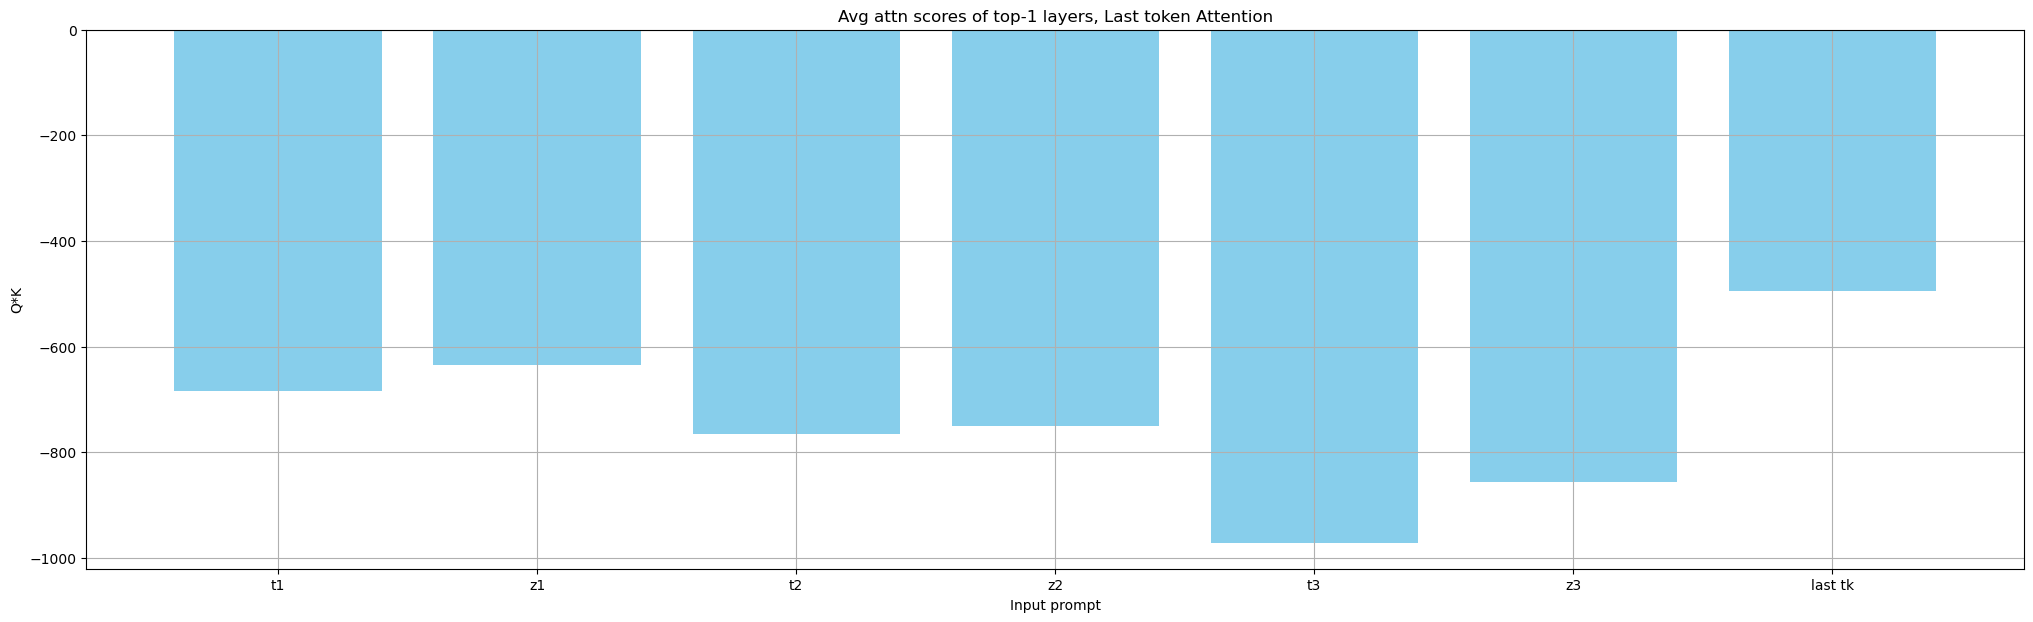

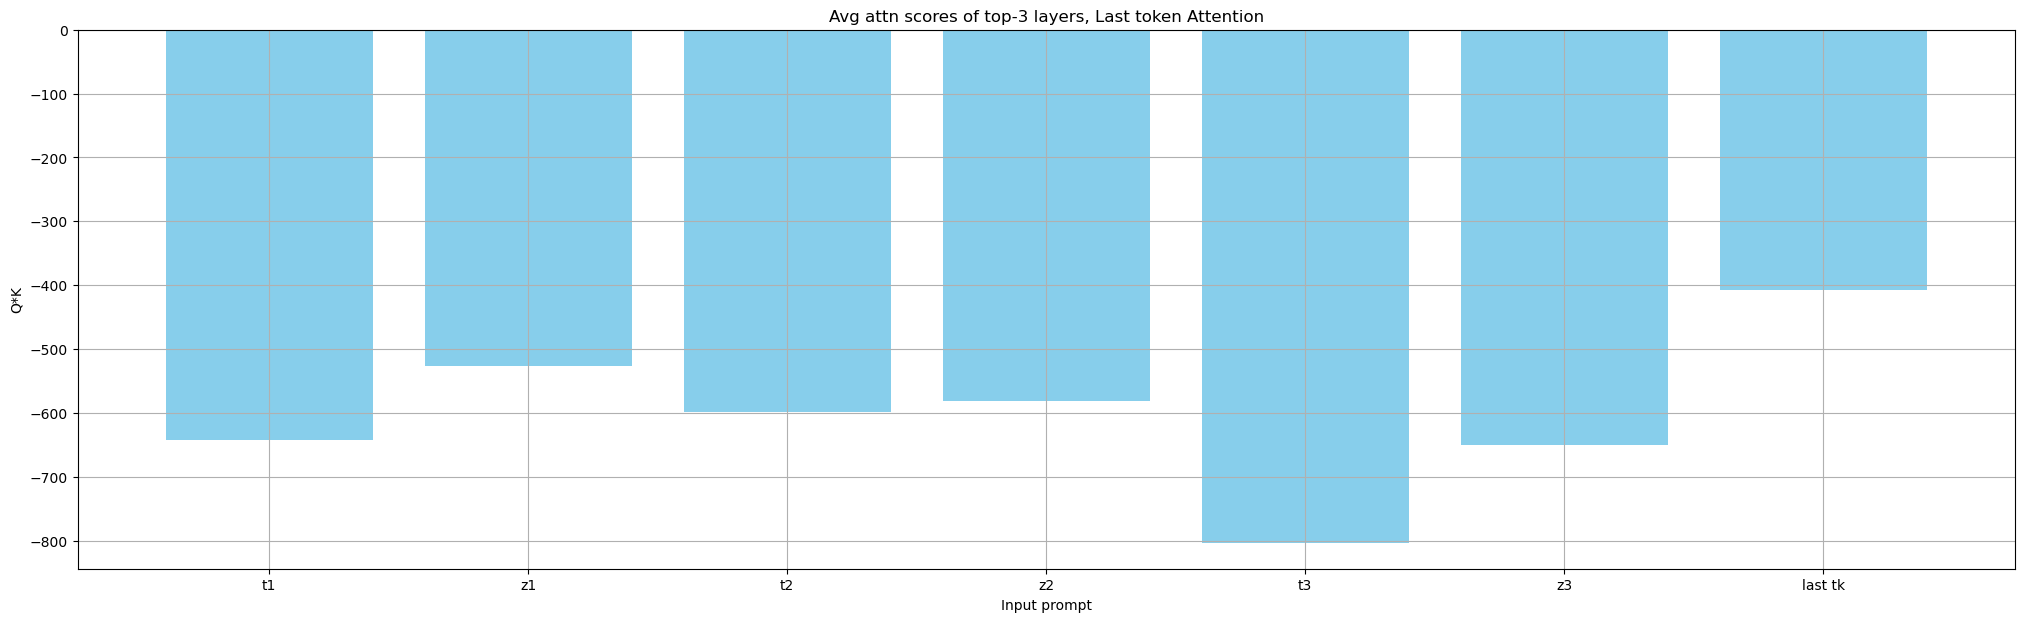

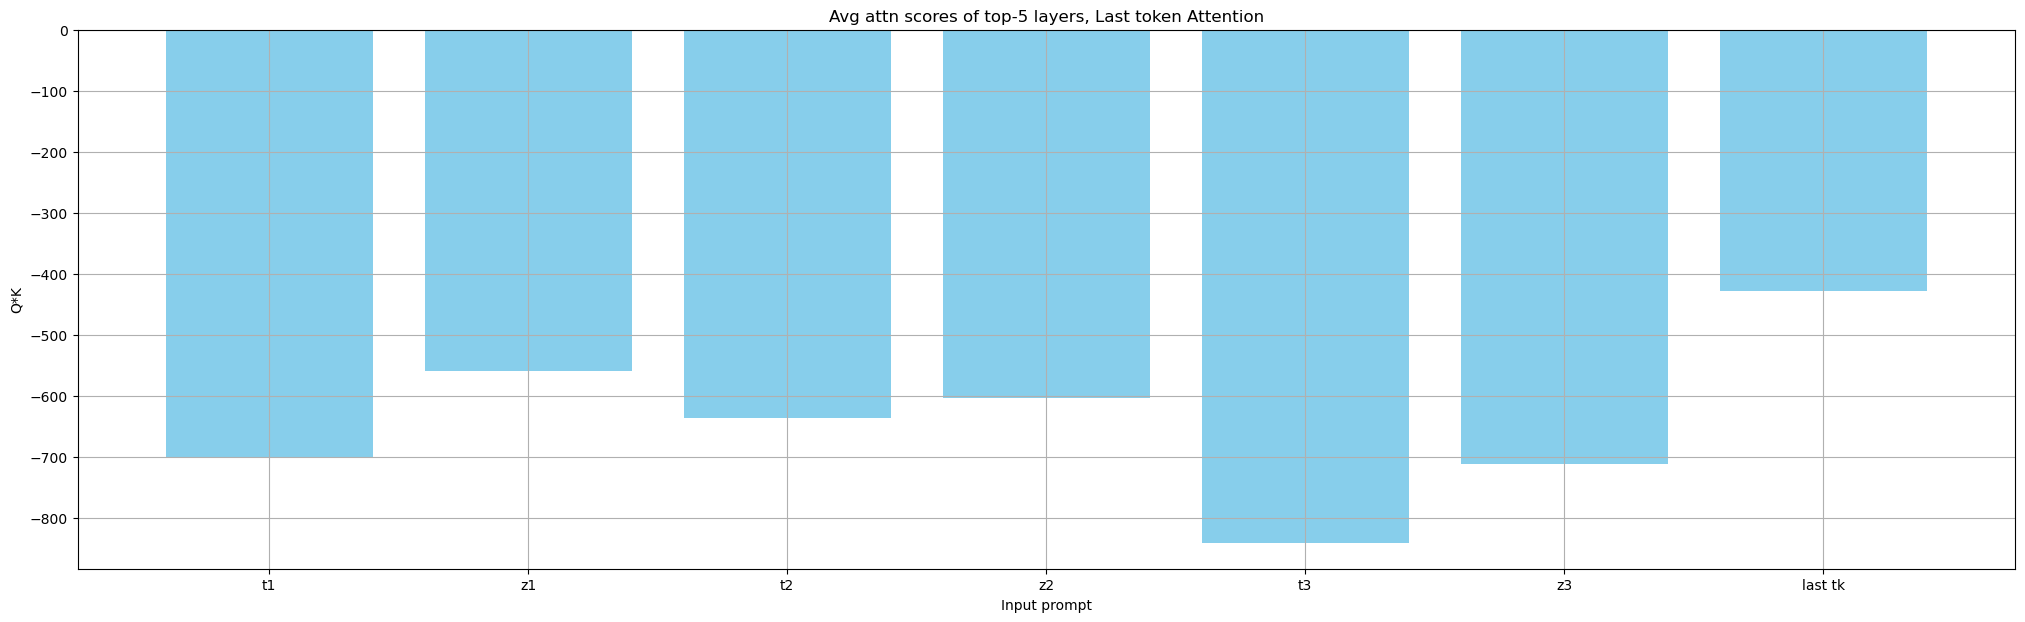

In [ ]:
'''
compute the attention score of the last token's Q and the label's K.
'''


tks=get_tokens(model, tokenizer, prompt, device).squeeze(0)
if target_word=='bar':
    contras_word='foo'
    target_label_poss=torch.where(tks==2594)[0]
    contras_label_poss=torch.where(tks==7953)[0]
elif target_word=='foo':
    contras_word='bar'
    target_label_poss=torch.where(tks==7953)[0]
    contras_label_poss=torch.where(tks==2594)[0]
elif target_word=='positive':
    contras_word='negative'
    target_label_poss=torch.where(tks==6374)[0]
    contras_label_poss=torch.where(tks==8178)[0]
elif target_word=='negative':
    contras_word='positive'
    target_label_poss=torch.where(tks==8178)[0]
    contras_label_poss=torch.where(tks==6374)[0]


if ana_module=='by_head':
    num_top_heads_to_avgs=[1,3,5,8,10,15,20]
    if attn_obj=='labels':
        for num_top_heads_to_avg in num_top_heads_to_avgs:
        # if samples are seperated by '\n' and every label words are one-token, then the label tokens' positions are 
        # the ones before the '\n' token (13).
            label_poss=torch.where(tks==13)[0]-1
            avg_atten_scores=torch.zeros(num_top_heads_to_avg, len(label_poss)+1).to(device)
            for i in range(num_top_heads_to_avg):
                top_head_l, top_head_h=topk_ids_result[i,0].int(), topk_ids_result[i,1].int()
                last_token_Q=rep[attn_Q[top_head_l]].output.squeeze(0)[-1, top_head_h*head_dim:(top_head_h+1)*head_dim] # print(last_token_Q.shape) = [128], i.e., [head_dim]
                last_token_K=rep[attn_K[top_head_l]].output.squeeze(0)[-1, top_head_h*head_dim:(top_head_h+1)*head_dim]
                label_K=rep[attn_K[top_head_l]].output.squeeze(0)[label_poss, top_head_h*head_dim:(top_head_h+1)*head_dim] # label_K.shape = torch.Size([4, 128]), i.e., [num_examples, head_dim]
                attn_scores=torch.cat((torch.mm(label_K, last_token_Q.view(-1,1)), torch.dot(last_token_Q, last_token_K).view(1,1)), dim=0).view(len(label_poss)+1)
                
                avg_atten_scores[i]=attn_scores
            avg_atten_scores=avg_atten_scores.mean(dim=0)
            #print(avg_atten_scores)

            if task_name=='antonym':
                context_label_words = ['easy', 'right', 'bad', 'lose', 'safe', 'last tk']
            elif 'sentiment' in task_name:
                context_label_words = ['t1', 'z1', 't2', 'z2', 't3', 'z3', 'last tk']
            elif 'classification' in task_name:
                context_label_words = ['foo1', 'foo2', 'foo3', 'bar1', 'bar2', 'bar3', 'last tk']

            plt.bar(context_label_words, avg_atten_scores.detach().cpu().numpy(), color='skyblue')
            plt.title(f'Avg attn scores of top-{num_top_heads_to_avg} heads, Last token Attention')
            plt.xlabel('Context labels')
            plt.ylabel('Q*K')
            plt.grid(True)
            plt.savefig(f'./visualization/attn/by_head/last_tk_labels_attn_score/avg_top_{num_top_heads_to_avg}_heads_attn_score_'+task_name+spec_str+'.jpg')
            plt.show()

    elif attn_obj=='all':
        for num_top_heads_to_avg in num_top_heads_to_avgs:
            avg_atten_scores=torch.zeros(num_top_heads_to_avg, len(tks)).to(device)
            for i in range(num_top_heads_to_avg):
                top_head_l, top_head_h=topk_ids_result[i,0].int(), topk_ids_result[i,1].int()
                last_token_Q=rep[attn_Q[top_head_l]].output.squeeze(0)[-1, top_head_h*head_dim:(top_head_h+1)*head_dim] # print(last_token_Q.shape) = [128], i.e., [head_dim]
                context_K=rep[attn_K[top_head_l]].output.squeeze(0)[:, top_head_h*head_dim:(top_head_h+1)*head_dim] # label_K.shape = torch.Size([4, 128]), i.e., [num_examples, head_dim]
                #print(torch.dot(last_token_Q, last_token_K).view(1,1))
                attn_scores=torch.mm(context_K, last_token_Q.view(-1,1)).view(len(tks))
                avg_atten_scores[i]=attn_scores

            avg_atten_scores=avg_atten_scores.mean(dim=0)
            #print(avg_atten_scores)


            context_label_words = get_tk_words(tokenizer, tks)
            print(context_label_words)
            plt.figure(figsize=(25, 7))
            plt.bar(range(len(context_label_words)), avg_atten_scores.detach().cpu().numpy(), tick_label=context_label_words, color='skyblue')
            plt.title(f'Avg attn scores of top-{num_top_heads_to_avg} heads, Last token Attention')
            plt.xlabel('Input prompt')
            plt.ylabel('Q*K')
            plt.grid(True)
            plt.savefig(f'./visualization/attn/by_head/last_tk_all_attn_score/avg_top_{num_top_heads_to_avg}_heads_attn_score_'+task_name+spec_str+'.jpg')
            plt.show()
elif ana_module=='all_heads':
    num_top_layers_to_avgs=[1,3,5]
    label_poss=torch.where(tks==13)[0]-1
    for num_top_layers_to_avg in num_top_layers_to_avgs:
        avg_atten_scores=torch.zeros(num_top_layers_to_avg, len(label_poss)+1).to(device)
        if attn_obj=='labels':
            label_poss=torch.where(tks==13)[0]-1
            avg_atten_scores=torch.zeros(num_top_layers_to_avg, len(label_poss)+1).to(device)
        elif attn_obj=='all':
            avg_atten_scores=torch.zeros(num_top_layers_to_avg, len(tks)).to(device)
        for l in range(num_top_layers_to_avg):
            last_token_Q=rep[attn_Q[topk_layer_inds[l]]].output.squeeze(0)[-1, :] # print(last_token_Q.shape) = [128], i.e., [head_dim]
            if attn_obj=='labels':
                label_K=rep[attn_K[topk_layer_inds[l]]].output.squeeze(0)[label_poss, :]
                last_token_K=rep[attn_K[topk_layer_inds[l]]].output.squeeze(0)[-1, :]
                attn_scores=torch.cat((torch.mm(label_K, last_token_Q.view(-1,1)), torch.dot(last_token_Q, last_token_K).view(1,1)), dim=0).view(len(label_poss)+1)
                if task_name=='antonym':
                    context_label_words = ['easy', 'right', 'bad', 'lose', 'safe', 'last tk']
                elif 'sentiment' in task_name:
                    context_label_words = ['t1', 'z1', 't2', 'z2', 't3', 'z3', 'last tk']
            elif attn_obj=='all':
                context_K=rep[attn_K[topk_layer_inds[l]]].output.squeeze(0)[:, :] # label_K.shape = torch.Size([4, 128]), i.e., [num_examples, head_dim]
                attn_scores=torch.mm(context_K, last_token_Q.view(-1,1)).view(len(tks))
                context_label_words = get_tk_words(tokenizer, tks)
            avg_atten_scores[l]=attn_scores
        avg_atten_scores=avg_atten_scores.mean(dim=0)
        
        plt.figure(figsize=(25, 7))
        plt.bar(range(len(context_label_words)), avg_atten_scores.detach().cpu().numpy(), tick_label=context_label_words, color='skyblue')
        plt.title(f'Avg attn scores of top-{num_top_layers_to_avg} layers, Last token Attention')
        plt.xlabel('Input prompt')
        plt.ylabel('Q*K')
        plt.grid(True)
        plt.savefig('./visualization/attn/all_heads/last_tk_'+attn_obj+f'_attn_score/avg_top_{num_top_layers_to_avg}_heads_attn_score_'+task_name+spec_str+'.jpg')
        plt.show()
elif ana_module=='spec_head':
    attn_score_storage=torch.zeros(n_heads, n_layers).to(device)
    for l in range(n_layers):
        for h in range(n_heads):
            last_token_Q=rep[attn_Q[l]].output.squeeze(0)[-1, h*head_dim:(h+1)*head_dim]
            target_label_K=rep[attn_K[l]].output.squeeze(0)[target_label_poss, h*head_dim:(h+1)*head_dim] 
            contras_label_K=rep[attn_K[l]].output.squeeze(0)[contras_label_poss, h*head_dim:(h+1)*head_dim]
            target_attn_score=torch.mm(target_label_K, last_token_Q.view(-1, 1)).view(target_label_poss.shape[0]).sum(0)
            contras_attn_score=torch.mm(contras_label_K, last_token_Q.view(-1, 1)).view(contras_label_poss.shape[0]).sum(0)
            attn_score=torch.softmax(torch.cat((target_attn_score.unsqueeze(0), contras_attn_score.unsqueeze(0))),0)
            
            attn_score_storage[l,h]=attn_score[0] - attn_score[1]
            
            '''label_words=[target_word, contras_word]
            values=attn_score.detach().cpu().numpy()
            bar=plt.bar(label_words, values, color='skyblue')
            plt.bar_label(bar, label_type='edge')'''
    
    plt.imshow(attn_score_storage.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    plt.colorbar()  
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title('Attention on target label - contras label (after sftmx)')
    plt.savefig(f'./visualization/attn/by_head/traverse/target-contras_attn_'+task_name+spec_str+'.jpg')
    plt.savefig(f'./visualization/attn/by_head/traverse/target-contras_attn_'+task_name+spec_str+'.pdf')
    plt.show()
    
elif ana_module=='spec_layer':
    l=10
    label_poss=torch.where(tks==13)[0]-1
    if attn_obj=='labels':
        label_poss=torch.where(tks==13)[0]-1
    last_token_Q=rep[attn_Q[l]].output.squeeze(0)[-1, :] # print(last_token_Q.shape) = [128], i.e., [head_dim]
    if attn_obj=='labels':
        label_K=rep[attn_K[l]].output.squeeze(0)[label_poss, :]
        last_token_K=rep[attn_K[l]].output.squeeze(0)[-1, :]
        attn_scores=torch.cat((torch.mm(label_K, last_token_Q.view(-1,1)), torch.dot(last_token_Q, last_token_K).view(1,1)), dim=0).view(len(label_poss)+1)
        if task_name=='antonym':
            context_label_words = ['easy', 'right', 'bad', 'lose', 'safe', 'last tk']
        elif 'sentiment' in task_name:
            context_label_words = ['t1', 'z1', 't2', 'z2', 't3', 'z3', 'last tk']
    elif attn_obj=='all':
        context_K=rep[attn_K[l]].output.squeeze(0)[:, :] # label_K.shape = torch.Size([4, 128]), i.e., [num_examples, head_dim]
        attn_scores=torch.mm(context_K, last_token_Q.view(-1,1)).view(len(tks))
        context_label_words = get_tk_words(tokenizer, tks)

    attn_score_sftmx=torch.softmax(attn_scores, dim=0)
    if attn_obj=='all':
        spec_str+='_all'
    elif attn_obj=='labels':
        spec_str+='_labels'
    
    plt.figure(figsize=(25, 7))
    plt.bar(range(len(context_label_words)), attn_score_sftmx.detach().cpu().numpy(), tick_label=context_label_words, color='skyblue')
    plt.title(f'Attn scores of layer {l}, Last token Attention')
    plt.xlabel('Input prompt')
    plt.ylabel('Q*K sftmx')
    plt.grid(True)
    plt.savefig('./visualization/attn/all_heads/last_tk_'+attn_obj+f'_attn_score/attn_score_layer_{l}_'+task_name+spec_str+'.jpg')
    plt.show()

